### Rotation of horizontal velocities from EM-APEX floats to along-track and cross-track


1. The float track GPS positions are smoothed with a Savitz-Golay filter - fits a 3rd degree polynomial to a centered rolling window of 9 points.


2. The bearing from one GPS location to the next is the along-track bearing.


3. We calculate the angle, $\theta$, between the along-track bearing and the velocity bearing from the absolute velocities at every depth. 


Along-track velocity, $u_{rot} = speed \times \cos(\theta \times \frac{\pi}{180})$

Cross-track velocity, $v_{rot} = speed \times \sin(\theta \times \frac{\pi}{180})$


For further smoothing, we evenly grid in distance (3 km intervals) and horizontally smooth on pressure levels using a 3rd degree Savitz-Golay filter with a centered rolling window of 3 profiles (9 km). 

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cmocean
import datetime
import math
import gsw
import stat
import scipy
import pyproj

%matplotlib inline

plt.rcParams['font.size'] = '14'

In [ ]:
workingdir = r'C:\Users\mijakes\checkouts\phd-public'
os.chdir(workingdir) 

In [2]:
import imp
import src.importData as imports
import src.calc as calc
import src.plots as plots
import src.velocities as vel
import src.concat as ct
import src.interpolation as interp
import src.settings as settings
import src.stats as stats

In [3]:
# import float data
floatids = [8489, 8492, 8493]
ema = imports.importFloatData(floatids)

# import satellite data
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
alt_cmems = imports.importNetCDF(datadir, 'CMEMS.nc', datatype ='altimetry')

In [40]:
imp.reload(imports)
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
ds = imports.sub_inertial_ds(ema, floatids, datadir, xdim = 'profile')

In [49]:
imp.reload(vel)

u_rot = {}
v_rot = {}
theta = {}
abs_vels = {}
for floatid in floatids:
    u, v = ds[floatid].u_abs, ds[floatid].v_abs
    
    # rotate velocities
    u_rot[floatid], v_rot[floatid], theta[floatid] = vel.rotate_velocities_old_method(ema[floatid], floatid, u, v, 
                                                                        smooth_vels = False, smooth_gps = False, window = 9)
    
    
    #absolute velocities
    file = os.path.join(datadir, 'absolute_velocity', 'by_profile', 'abs_vel_%s_extra_qc.nc' %floatid)
    abs_vels[floatid] = xr.open_dataset(file)

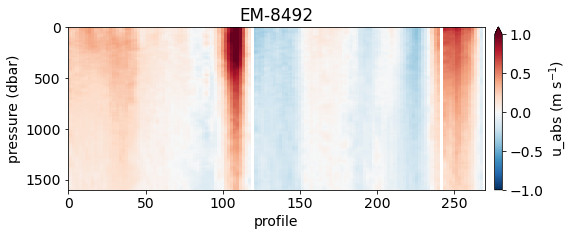

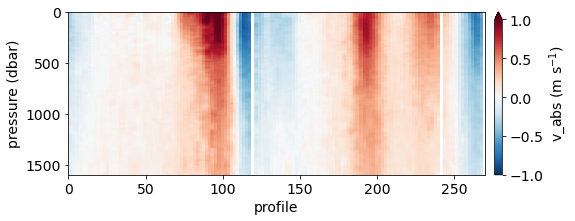

In [43]:
floatid = 8492

fig, ax = plt.subplots(figsize = (9, 3))
ds[floatid].u_abs.plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r', 
                    cbar_kwargs = dict(label = 'u_abs (m s$^{-1}$)', pad = 0.02))
ax.invert_yaxis()
plt.xlabel('profile')
plt.ylabel('pressure (dbar)')
plt.title('EM-8492')

my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter2_manuscript', 'revision_figures')
# settings.save_figure(fig, my_path, 'u_abs_no_inert.png', dpi = 600, pad = 0.2)

fig, ax = plt.subplots(figsize = (9, 3))
ds[floatid].v_abs.plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r', 
                    cbar_kwargs = dict(label = 'v_abs (m s$^{-1}$)', pad = 0.02))
ax.invert_yaxis()
plt.xlabel('profile')
plt.ylabel('pressure (dbar)')

# settings.save_figure(fig, my_path, 'v_abs_no_inert.png', dpi = 600, pad = 0.2)

Text(0, 0.5, 'pressure (dbar)')

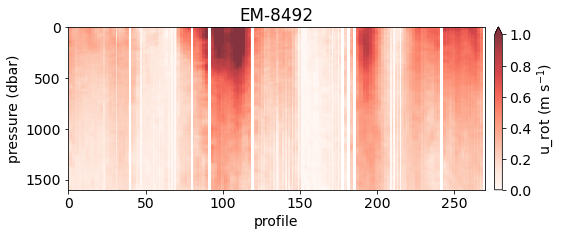

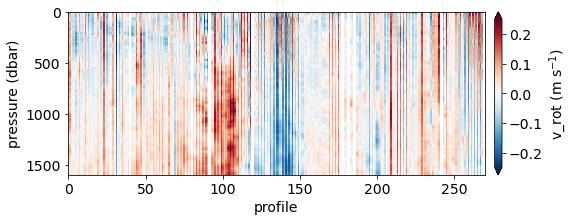

In [51]:
floatid = 8492

fig, ax = plt.subplots(figsize = (9, 3))
u_rot[floatid].plot(x = 'profile', vmin = 0, vmax = 1, cmap = 'Reds', alpha = 0.8,
                    cbar_kwargs = dict(label = 'u_rot (m s$^{-1}$)', pad = 0.02, extend = 'max'))
ax.invert_yaxis()
plt.xlabel('profile')
plt.ylabel('pressure (dbar)')
plt.title('EM-8492')

my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter2_manuscript', 'revision_figures')
# settings.save_figure(fig, my_path, 'u_rot_smooth_gps.png', dpi = 600, pad = 0.2)
# settings.save_figure(fig, my_path, 'u_rot_unsmoothed_gps.png', dpi = 600, pad = 0.2)

fig, ax = plt.subplots(figsize = (9, 3))
v_rot[floatid].plot(x = 'profile', vmin = -0.25, vmax = 0.25, cmap = 'RdBu_r', 
                    cbar_kwargs = dict(label = 'v_rot (m s$^{-1}$)', pad = 0.02))
ax.invert_yaxis()
plt.xlabel('profile')
plt.ylabel('pressure (dbar)')

# settings.save_figure(fig, my_path, 'v_rot_smooth_gps.png', dpi = 600, pad = 0.2)
# settings.save_figure(fig, my_path, 'v_rot_unsmoothed_gps.png', dpi = 600, pad = 0.2)

In [40]:
rs = calc.findRSperiod(ema[floatid])
along_stream = vel.floatTrackBearing_old_method(ema[floatid], smooth_gps = True, window = 9)[rs]

lons = interp.gaussianFilter(ema[floatid].longitude, window = 9, interp_na = True)
lats = interp.gaussianFilter(ema[floatid].latitude, window = 9, interp_na = True)

In [47]:
theta_8492 = theta[floatid].assign_coords({'profile':np.arange(0, len(theta[floatid]), 1)})

Text(0.5, 1.0, 'profile 100-115')

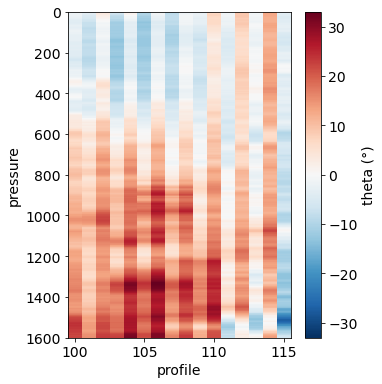

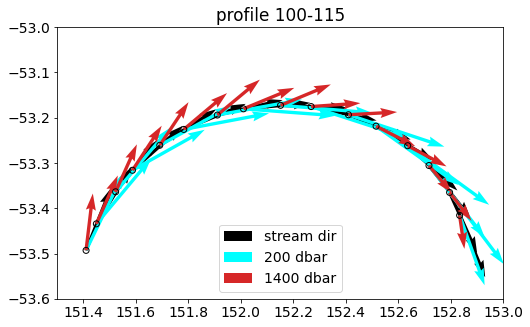

In [48]:
prof1, prof2 = 100,116
p1, p2 = 200, 1400

fig, ax = plt.subplots(figsize = (5,6))
theta_8492[prof1:prof2].plot(x = 'profile', cbar_kwargs = dict(label = 'theta (\N{DEGREE SIGN})'))
ax.invert_yaxis()


u1 = ds[floatid].u_abs[prof1:prof2].sel(pressure = p1, method = 'nearest')
v1 = ds[floatid].v_abs[prof1:prof2].sel(pressure = p1, method = 'nearest')

u2 = ds[floatid].u_abs[prof1:prof2].sel(pressure = p2, method = 'nearest')
v2 = ds[floatid].v_abs[prof1:prof2].sel(pressure = p2, method = 'nearest')

angle_rad = np.deg2rad(along_stream)
y2 = 0.3 * np.cos(angle_rad) 
x2 = 0.3 * np.sin(angle_rad) 
    
fig, ax = plt.subplots(figsize = (8, 5))
plt.quiver(lons[prof1:prof2], lats[prof1:prof2], x2[prof1:prof2], y2[prof1:prof2], color = 'k', scale = 2)
plt.quiver(lons[prof1:prof2], lats[prof1:prof2], u1, v1, color = 'cyan', scale = 5)
plt.quiver(lons[prof1:prof2], lats[prof1:prof2], u2, v2, color = 'tab:red', scale = 3)
plt.legend(['stream dir', f'{p1} dbar', f'{p2} dbar'], loc = 'lower center')
plt.scatter(lons[prof1:prof2], lats[prof1:prof2], facecolors = 'None', edgecolors = 'k', linewidths = 1)

plt.ylim(-53.6, -53)
plt.xlim(151.3, 153)
plt.title(f'profile {prof1}-{prof2-1}')

In [49]:
shp = theta_8492.shape
diff_theta = np.zeros(shp)#*np.nan

for i in range(0, len(theta_8492), 2):
    diff_theta[i] = (theta_8492[i] - theta_8492[i+1])
#     diff_u[i+1] = (u_rel[floatid][rs][i] - u_rel[floatid][rs][i+1])

diff_theta = xr.DataArray(diff_theta, dims = ['profile', 'pressure'], coords = theta_8492.coords)    

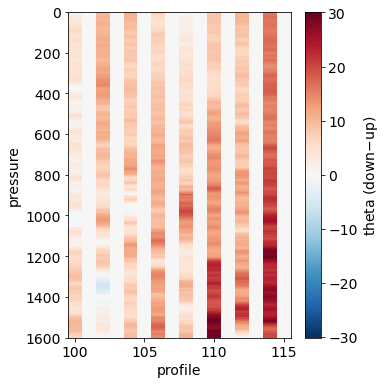

In [50]:
fig, ax = plt.subplots(figsize = (5,6))
diff_theta[prof1:prof2].plot(x = 'profile', cbar_kwargs = dict(label = 'theta (down$-$up)'))
ax.invert_yaxis()

### Concatenated floats

In [33]:
# # import half-inertial pair averaged dataset
# datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
# ds = imports.sub_inertial_ds(ema, floatids, datadir, xdim = 'distance')

In [34]:
abs_vels = {}
abs_vels_prof = {}
u_abs = {}
v_abs = {}
CT, SA = {}, {}
ctd_time = {}

for floatid in floatids:
    # absolute velocities (no averaging) 
    file_1 = os.path.join(datadir, 'absolute_velocity', 'by_distance', 'abs_vel_%s_extra_qc.nc' %floatid)
    abs_vels[floatid] = xr.open_dataset(file_1)
    
    file_2 = os.path.join(datadir, 'absolute_velocity', 'by_profile', 'abs_vel_%s_extra_qc.nc' %floatid)
    abs_vels_prof[floatid] = xr.open_dataset(file_2)
    
    # sub-inertial absolute velocities 
    u_abs[floatid], v_abs[floatid] = ds[floatid].u, ds[floatid].v
    
    # sub-inertial temperature and salinity
    CT[floatid], SA[floatid] = ds[floatid].CT, ds[floatid].SA
    
    # time recorded from float ctd
    floatdir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats', 'extra_vars')
    input_file = os.path.join(floatdir, 'macquarie_ema-%s_qc.nc' %floatid)
    float_num = xr.open_dataset(input_file)
    ctd_time[floatid] = float_num.ctd_t

AttributeError: 'Dataset' object has no attribute 'u'

In [533]:
# potential density density
imp.reload(ct)

S_concat, end_dist, d_rs = ct.concatenated_flts(SA, floatids, interp_to_dens = False, new_dim = True)
T_concat, end_dist, d_rs = ct.concatenated_flts(CT, floatids, interp_to_dens = False, new_dim = True)
pdens = calc.potentialDensity(S_concat.pressure, S_concat, T_concat)
levels = np.arange(26.8,27.8,0.1)

In [534]:
# mixed layer depth
mld = {}
mld_on_d = {}
for floatid in floatids:
    mld_on_d[floatid] = calc.MLD_on_dens(ds[floatid], floatid)
    mld[floatid] = calc.MLD_float(ds[floatid], floatid, plot = False)

mld_ds, end_dist, d_rs = ct.concatenated_flts(mld_on_d, floatids, new_dim = True)
mld_on_p, end_dist, d_rs = ct.concatenated_flts(mld, floatids, new_dim = True)

### Absolute velocities

In [535]:
u_abs_concat, end_dist, d_rs = ct.concatenated_flts(u_abs, floatids, interp_to_dens = False, new_dim = True)
v_abs_concat, end_dist, d_rs = ct.concatenated_flts(v_abs, floatids, interp_to_dens = False, new_dim = True)
ticks, values, flt_dist_loc = plots.concatTickValues(d_rs)

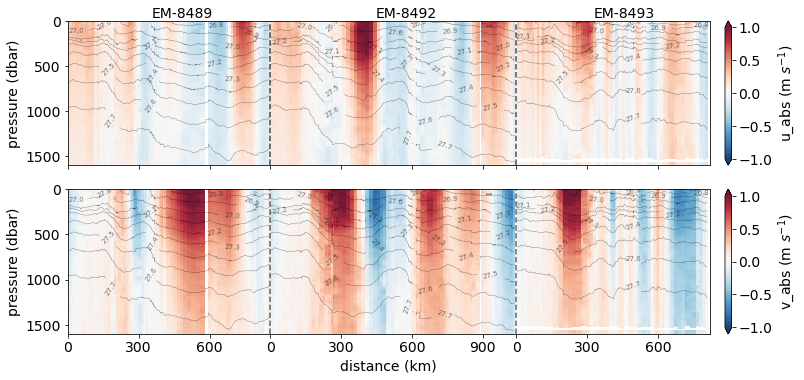

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, sharey = True, figsize = (12,5.5))

#zonal velocity
im1 = u_abs_concat.plot(ax = ax1, x = 'distance', cmap = 'RdBu_r', vmin = -1, vmax = 1, alpha = 0.9, extend = 'both',
                                            cbar_kwargs={"label": "u_abs (m $s^{-1}$)", 'pad':0.02})

for i in range(0,len(flt_dist_loc)):
    ax1.axvline(x = flt_dist_loc[i], linestyle = '--', color = 'k', alpha = 0.7)
    ax2.axvline(x = flt_dist_loc[i], linestyle = '--', color = 'k', alpha = 0.6)
    
ax1.set_xticks(ticks)
ax1.set_xticklabels(values)

CS = pdens.plot.contour(ax = ax1, x = 'distance', colors = 'k', linewidths = 0.4, linestyles = 'solid', 
                                                                levels = levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=7, fmt = '%1.1f')

#meridional velocity   
im2 = v_abs_concat.plot(ax = ax2, x = 'distance', cmap = 'RdBu_r', vmin = -1, vmax = 1, alpha = 0.9, extend = 'both',
                                            cbar_kwargs={"label": "v_abs (m $s^{-1}$)", 'pad':0.02})

CS = pdens.plot.contour(ax = ax2, x = 'distance', colors = 'k', linewidths = 0.4, linestyles = 'solid', 
                                                                    levels = levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=7, fmt = '%1.1f')

ax1.invert_yaxis()
ax1.set_ylabel('pressure (dbar)')
ax1.set_xlabel('')
ax2.set_ylabel('pressure (dbar)')
ax2.set_xlabel('distance (km)')

ax1.text(0.13, 1.02, 'EM-8489', transform = ax1.transAxes)
ax1.text(0.48, 1.02, 'EM-8492', transform = ax1.transAxes)
ax1.text(0.82, 1.02, 'EM-8493', transform = ax1.transAxes)

plt.tight_layout()
plt.show()

### Is there an ascent/descent bias?

Text(0.5, 0, 'profile')

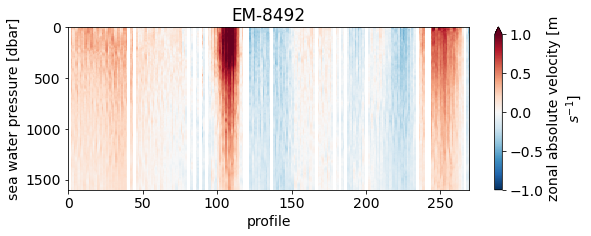

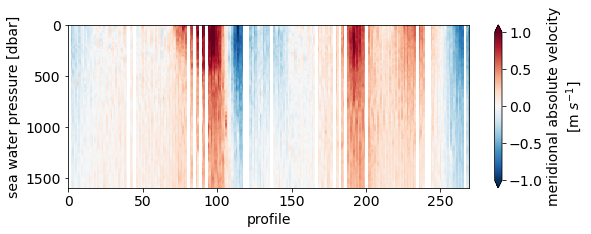

In [538]:
floatid = 8492
u_abs_prof = vel.setAbsVelToNan(floatid, abs_vels_prof[floatid].u_abs)
v_abs_prof = vel.setAbsVelToNan(floatid, abs_vels_prof[floatid].v_abs)
    
fig, ax = plt.subplots(figsize = (9, 3))
u_abs_prof.plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r')
ax.invert_yaxis()
plt.xlabel('profile')
plt.title('EM-8492')

fig, ax = plt.subplots(figsize = (9, 3))
v_abs_prof.plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r')
ax.invert_yaxis()
plt.xlabel('profile')

Text(0.5, 1.0, 'profile 160-161')

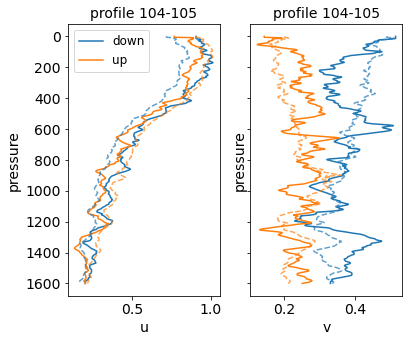

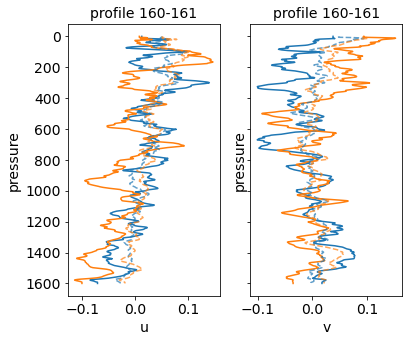

In [11]:
floatid = 8492
prof1 = 104
prof2 = prof1+1

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (6,5))
abs_vels[floatid].u_abs[prof1].plot(ax = ax1, y = 'pressure')
abs_vels[floatid].u_abs[prof2].plot(ax = ax1,y = 'pressure')
ax1.legend(['down', 'up'], fontsize = 12)
u_abs[floatid][prof1].plot(ax = ax1,y = 'pressure', c = 'tab:blue', linestyle = '--', alpha = 0.7)
u_abs[floatid][prof2].plot(ax = ax1,y = 'pressure', c = 'tab:orange', linestyle = '--', alpha = 0.7)

abs_vels[floatid].v_abs[prof1].plot(ax = ax2, y = 'pressure')
abs_vels[floatid].v_abs[prof2].plot(ax = ax2, y = 'pressure')
v_abs[floatid][prof1].plot(ax = ax2, y = 'pressure', c = 'tab:blue', linestyle = '--', alpha = 0.7)
v_abs[floatid][prof2].plot(ax = ax2, y = 'pressure', c = 'tab:orange', linestyle = '--', alpha = 0.7)
ax1.invert_yaxis()
ax1.set_title(f'profile {prof1}-{prof2}', fontsize = 14)
ax2.set_title(f'profile {prof1}-{prof2}', fontsize = 14)


prof1, prof2 = 160,161
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (6,5))
abs_vels[floatid].u_abs[prof1].plot(ax = ax1, y = 'pressure')
abs_vels[floatid].u_abs[prof2].plot(ax = ax1,y = 'pressure')
u_abs[floatid][prof1].plot(ax = ax1,y = 'pressure', c = 'tab:blue', linestyle = '--', alpha = 0.7)
u_abs[floatid][prof2].plot(ax = ax1,y = 'pressure', c = 'tab:orange', linestyle = '--', alpha = 0.7)

abs_vels[floatid].v_abs[prof1].plot(ax = ax2, y = 'pressure')
abs_vels[floatid].v_abs[prof2].plot(ax = ax2, y = 'pressure')
v_abs[floatid][prof1].plot(ax = ax2, y = 'pressure', c = 'tab:blue', linestyle = '--', alpha = 0.7)
v_abs[floatid][prof2].plot(ax = ax2, y = 'pressure', c = 'tab:orange', linestyle = '--', alpha = 0.7)
ax1.invert_yaxis()
ax1.set_title(f'profile {prof1}-{prof2}', fontsize = 14)
ax2.set_title(f'profile {prof1}-{prof2}', fontsize = 14)

Text(0.5, 0, 'profile')

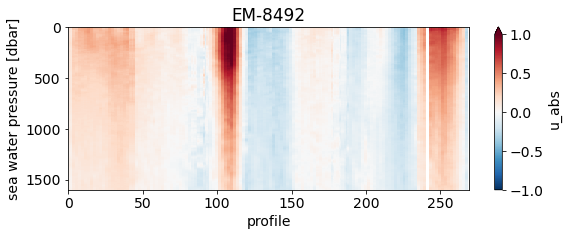

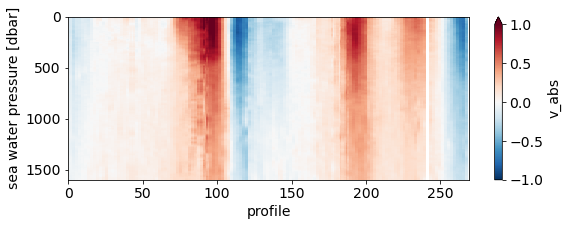

In [12]:
floatid = 8492
u_abs_prof_no_inert = xr.DataArray(u_abs[floatid], dims = u_abs_prof.dims, coords = u_abs_prof.coords)
v_abs_prof_no_inert = xr.DataArray(v_abs[floatid], dims = v_abs_prof.dims, coords = v_abs_prof.coords)
    
fig, ax = plt.subplots(figsize = (9, 3))
u_abs_prof_no_inert.plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r', cbar_kwargs = dict(label = 'u_abs'))
ax.invert_yaxis()
plt.xlabel('profile')
plt.title('EM-8492')

fig, ax = plt.subplots(figsize = (9, 3))
v_abs_prof_no_inert.plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r', cbar_kwargs = dict(label = 'v_abs'))
ax.invert_yaxis()
plt.xlabel('profile')

### Rotated velocities

Without any smoothing of float track gps positions (bearing from one profile to the next = stream direction)

smooth_gps = False

In [20]:
u_rot = {}
v_rot = {}
theta = {}
for floatid in floatids:
    
#     u = vel.setAbsVelToNan(floatid, abs_vels[floatid].u_abs)
#     v = vel.setAbsVelToNan(floatid, abs_vels[floatid].v_abs)
    
    #no inertial
    u = vel.setAbsVelToNan(floatid, ds[floatid].u_abs)
    v = vel.setAbsVelToNan(floatid, ds[floatid].v_abs)
    
    # rotate velocities
    u_rot[floatid], v_rot[floatid], theta[floatid] = vel.rotate_velocities_old_method(ema[floatid], floatid, u, v, 
                                                                        smooth_vels = False, smooth_gps = False,)

In [21]:
# imp.reload(ct)
# urot_ds, end_dist, u_dict = ct.concatenated_flts(u_rot, floatids, interp_to_dens = False, new_dim = True)
# vrot_ds, end_dist, v_dict = ct.concatenated_flts(v_rot, floatids, interp_to_dens = False, new_dim = True)

# ticks, values, flt_dist_loc = plots.concatTickValues(u_dict)

Text(0.5, 0, 'profile')

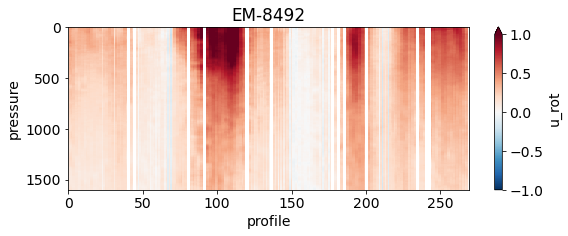

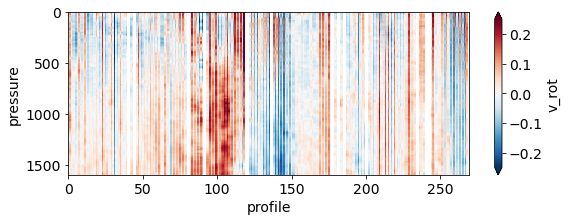

In [15]:
# v_rot_prof = xr.DataArray(v_rot[8492], dims = v_abs_prof.dims, coords = v_abs_prof.coords)
# u_rot_prof = xr.DataArray(u_rot[8492], dims = u_abs_prof.dims, coords = u_abs_prof.coords)

fig, ax = plt.subplots(figsize = (9, 3))
u_rot[8492].plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r', cbar_kwargs = dict(label = 'u_rot'))
ax.invert_yaxis()
plt.xlabel('profile')
plt.title('EM-8492')

fig, ax = plt.subplots(figsize = (9, 3))
v_rot[8492].plot(x = 'profile', vmin = -0.25, vmax = 0.25, cmap = 'RdBu_r', cbar_kwargs = dict(label = 'v_rot'))
ax.invert_yaxis()
plt.xlabel('profile')


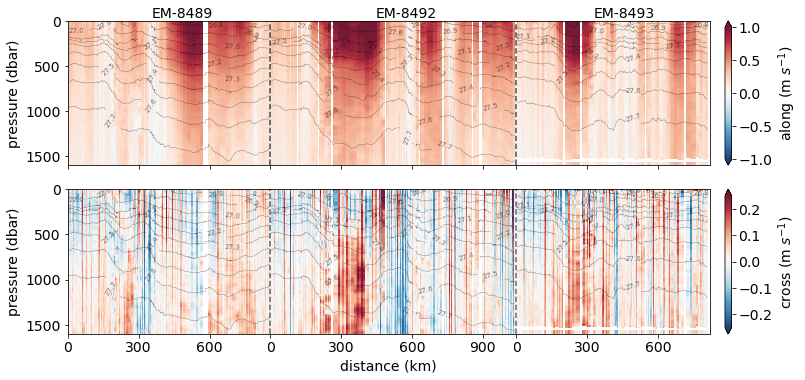

In [558]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, sharey = True, figsize = (12,5.5))

#along-trajectory
im1 = urot_ds.plot(ax = ax1, x = 'distance', cmap = 'RdBu_r', vmin = -1, vmax = 1, alpha = 0.9, extend = 'both',
                                            cbar_kwargs={"label": "along (m $s^{-1}$)", 'pad':0.02})

for i in range(0,len(flt_dist_loc)):
    ax1.axvline(x = flt_dist_loc[i], linestyle = '--', color = 'k', alpha = 0.7)
    ax2.axvline(x = flt_dist_loc[i], linestyle = '--', color = 'k', alpha = 0.6)
    
ax1.set_xticks(ticks)
ax1.set_xticklabels(values)

CS = pdens.plot.contour(ax = ax1, x = 'distance', colors = 'k', linewidths = 0.4, linestyles = 'solid', 
                                                                levels = levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=7, fmt = '%1.1f')


#cross-trajectory
im2 = vrot_ds.plot(ax = ax2, x = 'distance', cmap = 'RdBu_r', vmin = -0.25, vmax = 0.25, alpha = 0.9, extend = 'both',
                                            cbar_kwargs={"label": "cross (m $s^{-1}$)", 'pad':0.02})

CS = pdens.plot.contour(ax = ax2, x = 'distance', colors = 'k', linewidths = 0.4, linestyles = 'solid', 
                                                                    levels = levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=7, fmt = '%1.1f')

ax1.invert_yaxis()
ax1.set_ylabel('pressure (dbar)')
ax1.set_xlabel('')
ax2.set_ylabel('pressure (dbar)')
ax2.set_xlabel('distance (km)')

ax1.text(0.13, 1.02, 'EM-8489', transform = ax1.transAxes)
ax1.text(0.48, 1.02, 'EM-8492', transform = ax1.transAxes)
ax1.text(0.82, 1.02, 'EM-8493', transform = ax1.transAxes)

plt.tight_layout()
plt.show()

### Smoothing of gps positions using a centered rolling window of 9 profiles

smooth_gps = True, window = 9

no vertical smoothing of velocity profiles (smooth_vels = False)

In [559]:
imp.reload(vel)

u_rot = {}
v_rot = {}
theta = {}
for floatid in floatids:
     
    u = vel.setAbsVelToNan(floatid, abs_vels[floatid].u_abs)
    v = vel.setAbsVelToNan(floatid, abs_vels[floatid].v_abs)
    
    #no inertial
    u = vel.setAbsVelToNan(floatid, ds[floatid].u)
    v = vel.setAbsVelToNan(floatid, ds[floatid].v)
    
    # rotate velocities
    u_rot[floatid], v_rot[floatid], theta[floatid] = vel.rotate_velocities(ema[floatid], floatid, u, v, 
                                                                        smooth_vels = False, smooth_gps = True, window = 9)
    

In [560]:
imp.reload(ct)
urot_ds, end_dist, u_dict = ct.concatenated_flts(u_rot, floatids, interp_to_dens = False, new_dim = True)
vrot_ds, end_dist, v_dict = ct.concatenated_flts(v_rot, floatids, interp_to_dens = False, new_dim = True)

ticks, values, flt_dist_loc = plots.concatTickValues(u_dict)

Text(0.5, 0, 'profile')

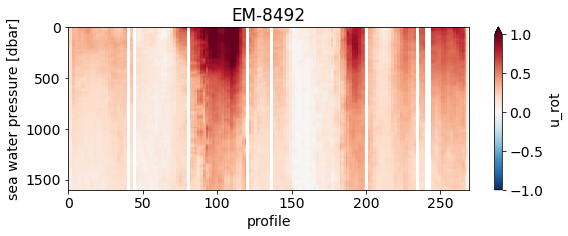

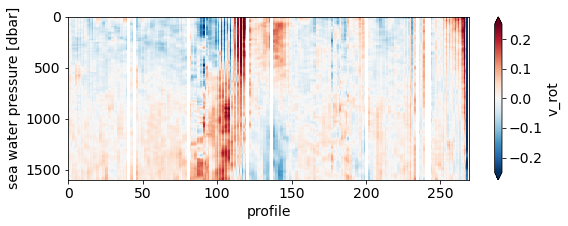

In [561]:
v_rot_prof = xr.DataArray(v_rot[8492], dims = v_abs_prof.dims, coords = v_abs_prof.coords)
u_rot_prof = xr.DataArray(u_rot[8492], dims = u_abs_prof.dims, coords = u_abs_prof.coords)

fig, ax = plt.subplots(figsize = (9, 3))
u_rot_prof.plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r', cbar_kwargs = dict(label = 'u_rot'))
ax.invert_yaxis()
plt.xlabel('profile')
plt.title('EM-8492')

fig, ax = plt.subplots(figsize = (9, 3))
v_rot_prof.plot(x = 'profile', vmin = -0.25, vmax = 0.25, cmap = 'RdBu_r', cbar_kwargs = dict(label = 'v_rot'))
ax.invert_yaxis()
plt.xlabel('profile')

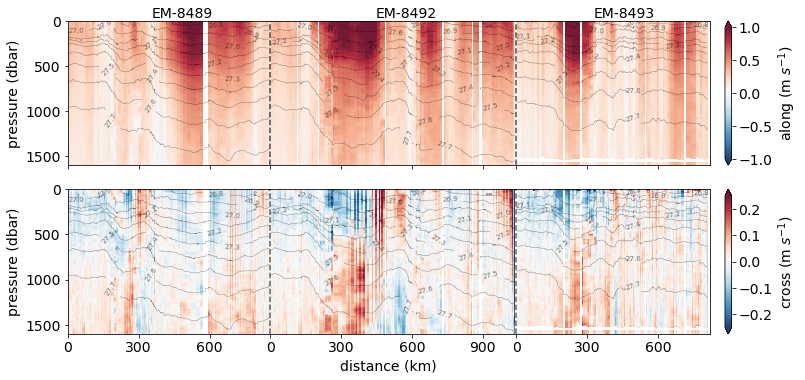

In [562]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, sharey = True, figsize = (12,5.5))

#along-trajectory
im1 = urot_ds.plot(ax = ax1, x = 'distance', cmap = 'RdBu_r', vmin = -1, vmax = 1, alpha = 0.9, extend = 'both',
                                            cbar_kwargs={"label": "along (m $s^{-1}$)", 'pad':0.02})

for i in range(0,len(flt_dist_loc)):
    ax1.axvline(x = flt_dist_loc[i], linestyle = '--', color = 'k', alpha = 0.7)
    ax2.axvline(x = flt_dist_loc[i], linestyle = '--', color = 'k', alpha = 0.6)
    
ax1.set_xticks(ticks)
ax1.set_xticklabels(values)

CS = pdens.plot.contour(ax = ax1, x = 'distance', colors = 'k', linewidths = 0.4, linestyles = 'solid', 
                                                                levels = levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=7, fmt = '%1.1f')


#cross-trajectory
im2 = vrot_ds.plot(ax = ax2, x = 'distance', cmap = 'RdBu_r', vmin = -0.25, vmax = 0.25, alpha = 0.9, extend = 'both',
                                            cbar_kwargs={"label": "cross (m $s^{-1}$)", 'pad':0.02})

CS = pdens.plot.contour(ax = ax2, x = 'distance', colors = 'k', linewidths = 0.4, linestyles = 'solid', 
                                                                    levels = levels, alpha = 0.5)
plt.clabel(CS, inline=True, fontsize=7, fmt = '%1.1f')

ax1.invert_yaxis()
ax1.set_ylabel('pressure (dbar)')
ax1.set_xlabel('')
ax2.set_ylabel('pressure (dbar)')
ax2.set_xlabel('distance (km)')

ax1.text(0.13, 1.02, 'EM-8489', transform = ax1.transAxes)
ax1.text(0.48, 1.02, 'EM-8492', transform = ax1.transAxes)
ax1.text(0.82, 1.02, 'EM-8493', transform = ax1.transAxes)

plt.tight_layout()
plt.show()

### Evenely gridded in distance (3 km intervals) and smoothed using a centered rolling average of 9 km.

In [20]:
imp.reload(interp)
T_even_concat, T_smooth_concat, T_smooth, T_even_dist = interp.grid_and_smooth(CT, floatids)
S_even_concat, S_smooth_concat, S_smooth, S_even_dist = interp.grid_and_smooth(SA, floatids)
pdens = calc.potentialDensity(S_even_concat.pressure, S_even_concat, T_even_concat)

mld_on_p = calc.MLD(pdens, criteria = 0.05, pref = 10)

In [21]:
u_even_concat, u_smooth_concat, u_smooth, u_even_dist = interp.grid_and_smooth(u_rot, floatids)
v_even_concat, v_smooth_concat, v_smooth, v_even_dist = interp.grid_and_smooth(v_rot, floatids)

Text(0.8, 1.02, 'EM-8493')

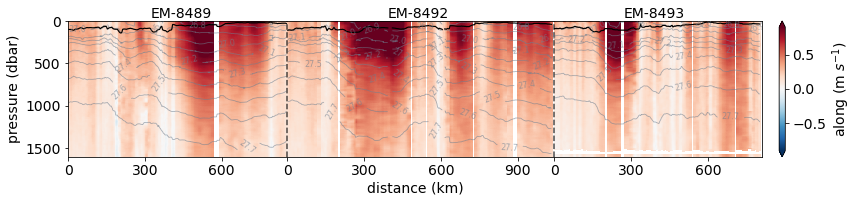

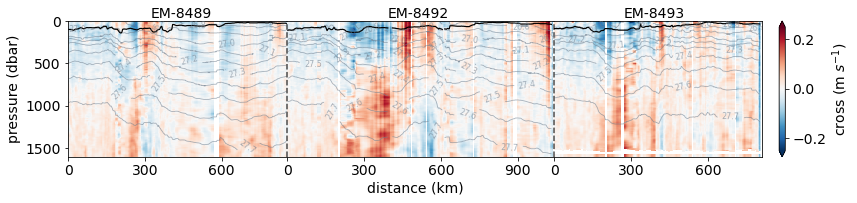

In [22]:
fig, ax = plt.subplots(figsize = (15,2.5))
im1 = u_smooth_concat.plot(x = 'distance', cmap = 'RdBu_r', vmin = -0.9, vmax = 0.9, #levels = np.arange(-0.85, 0.9, 0.05),
                                            cbar_kwargs={"label": "along (m $s^{-1}$)", 'pad': 0.02, 'extend':'both'})

for i in range(0,len(flt_dist_loc)):
    ax.axvline(x = flt_dist_loc[i], linestyle = '--', color = 'k', alpha = 0.7)
    
ax.set_xticks(ticks)
ax.set_xticklabels(values)

ax.plot(mld_on_p.distance, mld_on_p, c = 'k', linewidth = 1.2)
CS = pdens.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 0.8, levels = levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel('pressure (dbar)')
ax.text(0.12, 1.02, 'EM-8489', transform = ax.transAxes)
ax.text(0.46, 1.02, 'EM-8492', transform = ax.transAxes)
ax.text(0.8, 1.02, 'EM-8493', transform = ax.transAxes)

# my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter2_manuscript')
# settings.save_figure(fig, my_path, 'along_vels.png', dpi = 600, pad = 0.2)


fig, ax = plt.subplots(figsize = (15,2.5))
im1 = v_smooth_concat.plot(x = 'distance', cmap = 'RdBu_r', vmin = -0.25, vmax = 0.25, # levels = np.arange(-0.2, 0.225, 0.025),
                                            cbar_kwargs={"label": "cross (m $s^{-1}$)", 'pad': 0.02, 'extend':'both'})

for i in range(0,len(flt_dist_loc)):
    ax.axvline(x = flt_dist_loc[i], linestyle = '--', color = 'k', alpha = 0.7)
    
ax.set_xticks(ticks)
ax.set_xticklabels(values)

ax.plot(mld_on_p.distance, mld_on_p, c = 'k', linewidth = 1.2)
CS = pdens.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 0.8, levels = levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel('pressure (dbar)')
ax.text(0.12, 1.02, 'EM-8489', transform = ax.transAxes)
ax.text(0.46, 1.02, 'EM-8492', transform = ax.transAxes)
ax.text(0.8, 1.02, 'EM-8493', transform = ax.transAxes)

# my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter2_manuscript')
# settings.save_figure(fig, my_path, 'cross_vels.png', dpi = 600, pad = 0.2)

In [23]:
locs = {}
locs[8489] = [(180,220), (280,320)]
locs[8492] = [(220,310),(450,500)]
locs[8493] = [(260,330),(370,400)]

Text(0, 0.5, 'pressure (dbar)')

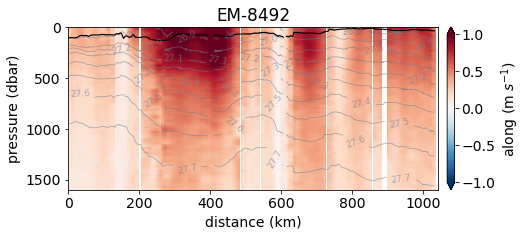

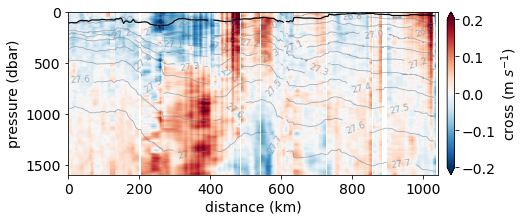

In [24]:
fig, ax = plt.subplots(figsize = (8,3))

pdens = calc.potentialDensity(S_even_dist[8492].pressure, S_even_dist[8492], T_even_dist[8492])
mld_on_p = calc.MLD(pdens, criteria = 0.05, pref = 10)

u_smooth[8492].plot(x = 'distance', cmap = 'RdBu_r', vmin = -1, vmax = 1, 
                                            cbar_kwargs={"label": "along (m $s^{-1}$)", 'pad': 0.02, 'extend':'both'})

ax.plot(mld_on_p.distance, mld_on_p, c = 'k', linewidth = 1.2)
CS = pdens.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 0.8, levels = levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=9, fmt = '%1.1f')

# for i in [0]:
#     d1, d2 = locs[8492][i][0], locs[8492][i][1]
#     d = T_even_dist[8492].distance.sel(distance = slice(d1,d2))
#     plt.plot(d, 0*np.arange(0, len(d))+5, c = 'k', linewidth = 7)

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel('pressure (dbar)')

plt.title('EM-8492')

# settings.save_figure(fig, my_path, 'along_8492.png', dpi = 600, pad = 0.2)


fig, ax = plt.subplots(figsize = (8,3))

pdens = calc.potentialDensity(S_even_dist[8492].pressure, S_even_dist[8492], T_even_dist[8492])
mld_on_p = calc.MLD(pdens, criteria = 0.05, pref = 10)

v_smooth[8492].plot(x = 'distance', cmap = 'RdBu_r', vmin = -0.2, vmax = 0.2, 
                                            cbar_kwargs={"label": "cross (m $s^{-1}$)", 'pad': 0.02, 'extend':'both'})

ax.plot(mld_on_p.distance, mld_on_p, c = 'k', linewidth = 1.2)
CS = pdens.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 0.8, levels = levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=9, fmt = '%1.1f')

# for i in [0]:
#     d1, d2 = locs[8492][i][0], locs[8492][i][1]
#     d = T_even_dist[8492].distance.sel(distance = slice(d1,d2))
#     plt.plot(d, 0*np.arange(0, len(d))+5, c = 'k', linewidth = 7)

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel('pressure (dbar)')

# settings.save_figure(fig, my_path, 'cross_8492.png', dpi = 600, pad = 0.2)

### Vertically smoothed (window = 75, 150 dbar), evenely gridded and horizontally smoothed on pressure levels (window = 3, 9 km).

In [460]:
u_smooth_concat = interp.grid_and_smooth(u_rot, floatids, vert_smooth = True)[1]
v_smooth_concat = interp.grid_and_smooth(v_rot, floatids, vert_smooth = True)[1]

Text(0.8, 1.02, 'EM-8493')

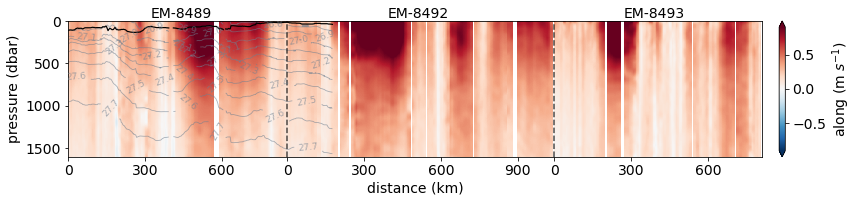

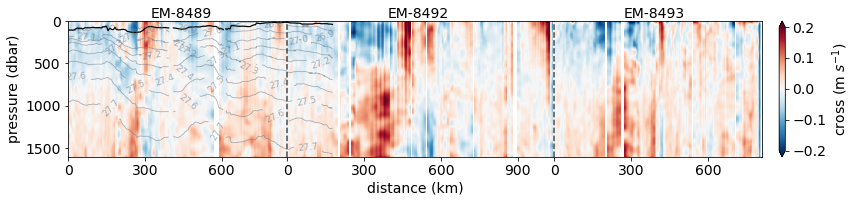

In [461]:
fig, ax = plt.subplots(figsize = (15,2.5))
im1 = u_smooth_concat.plot(x = 'distance', cmap = 'RdBu_r', vmin = -0.9, vmax = 0.9, #levels = np.arange(-0.85, 0.9, 0.05),
                                            cbar_kwargs={"label": "along (m $s^{-1}$)", 'pad': 0.02, 'extend':'both'})

for i in range(0,len(flt_dist_loc)):
    ax.axvline(x = flt_dist_loc[i], linestyle = '--', color = 'k', alpha = 0.7)
    
ax.set_xticks(ticks)
ax.set_xticklabels(values)

ax.plot(mld_on_p.distance, mld_on_p, c = 'k', linewidth = 1.2)
CS = pdens.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 0.8, levels = levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=9, fmt = '%1.1f')

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel('pressure (dbar)')
ax.text(0.12, 1.02, 'EM-8489', transform = ax.transAxes)
ax.text(0.46, 1.02, 'EM-8492', transform = ax.transAxes)
ax.text(0.8, 1.02, 'EM-8493', transform = ax.transAxes)


fig, ax = plt.subplots(figsize = (15,2.5))
im1 = v_smooth_concat.plot(x = 'distance', cmap = 'RdBu_r', vmin = -0.2, vmax = 0.2, # levels = np.arange(-0.2, 0.225, 0.025),
                                            cbar_kwargs={"label": "cross (m $s^{-1}$)", 'pad': 0.02, 'extend':'both'})

for i in range(0,len(flt_dist_loc)):
    ax.axvline(x = flt_dist_loc[i], linestyle = '--', color = 'k', alpha = 0.7)
    
ax.set_xticks(ticks)
ax.set_xticklabels(values)

ax.plot(mld_on_p.distance, mld_on_p, c = 'k', linewidth = 1.2)
CS = pdens.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 0.8, levels = levels, alpha = 0.6)
plt.clabel(CS, inline=True, fontsize=9, fmt = '%1.1f')

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel('pressure (dbar)')
ax.text(0.12, 1.02, 'EM-8489', transform = ax.transAxes)
ax.text(0.46, 1.02, 'EM-8492', transform = ax.transAxes)
ax.text(0.8, 1.02, 'EM-8493', transform = ax.transAxes)

## Individual floats

Plot the float track bearing with unsmoothed vs smoothed GPS positions. 

The bearing using smoothed GPS positions is used as a proxy for the stream direction.

In [1340]:
floatid = 8489
float_num = ema[floatid]
rs = calc.findRSperiod(float_num)

In [369]:
lons = interp.gaussianFilter(float_num.longitude, window = 9, interp_na = True)
lats = interp.gaussianFilter(float_num.latitude, window = 9, interp_na = True)

In [370]:
np.where((ds[floatid].distance < 600) & (ds[floatid].distance > 300))

(array([ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
        123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
        149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
        162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172], dtype=int64),)

Text(0.5, 1.0, 'profile 80-91')

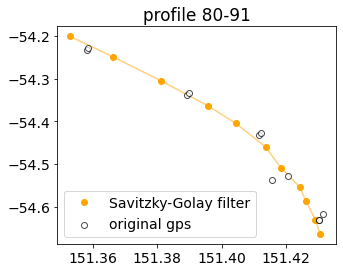

In [371]:
prof1, prof2 = 80,91
fig, ax = plt.subplots(figsize = (5,4))
plt.scatter(float_num.longitude[prof1:prof2], float_num.latitude[prof1:prof2], c = 'w',
            edgecolors = 'k',linewidths = 1, alpha = 0.7, zorder = 4)

plt.plot(lons[prof1:prof2], lats[prof1:prof2], 'o', c = 'orange')
plt.legend(['Savitzky-Golay filter', 'original gps'])

plt.plot(lons[prof1:prof2], lats[prof1:prof2], c = 'orange', alpha = 0.5)

plt.title(f'profile {prof1}-{prof2}')

Text(0.5, 1.0, 'profile 80-130')

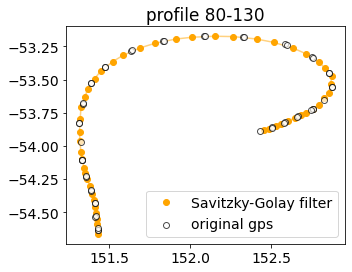

In [372]:
prof1, prof2 = 80,130
fig, ax = plt.subplots(figsize = (5,4))
plt.scatter(float_num.longitude[prof1:prof2], float_num.latitude[prof1:prof2], c = 'w',
            edgecolors = 'k',linewidths = 1, alpha = 0.7, zorder = 4)

plt.plot(lons[prof1:prof2], lats[prof1:prof2], 'o', c = 'orange')
plt.legend(['Savitzky-Golay filter', 'original gps'])

plt.plot(lons[prof1:prof2], lats[prof1:prof2], c = 'orange', alpha = 0.5)

plt.title(f'profile {prof1}-{prof2}')

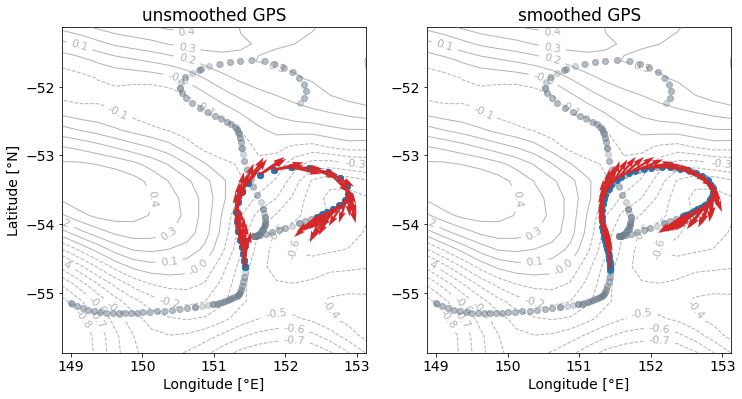

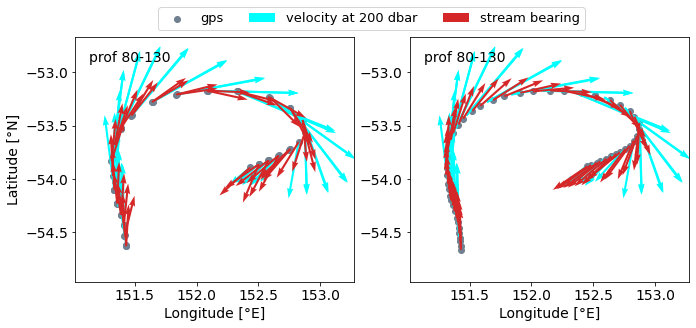

In [143]:
prof1 = 80
prof2 = 130

imp.reload(vel)
fig, fig2 = vel.plot_along_strm_dir(float_num, alt_cmems, prof1, prof2, window = 9, 
                                    u = ds[floatid].u, v = ds[floatid].v, scale = 2)

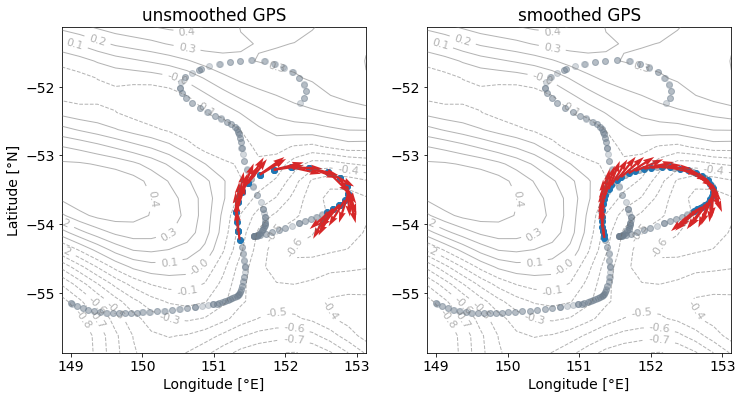

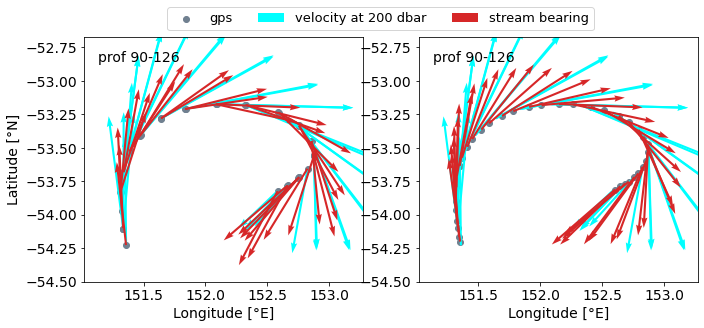

In [144]:
prof1 = 90
prof2 = 126 #len(float_num.CT[rs])-1

imp.reload(vel)
fig, fig2 = vel.plot_along_strm_dir(float_num, alt_cmems, prof1, prof2, window = 9, 
                                    u = ds[floatid].u, v = ds[floatid].v)

In [145]:
# my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter2_manuscript')
# settings.save_figure(fig2, my_path, 'stream_bearing_8489_90_126.png', dpi = 600, pad = 0.2)

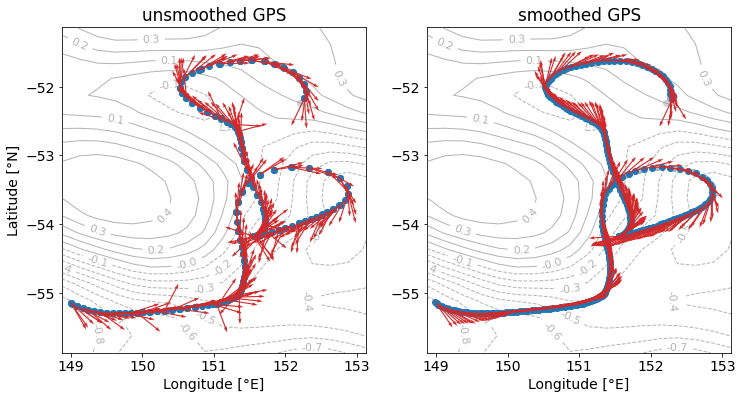

In [146]:
prof1 = 0
prof2 = 269
imp.reload(vel)
fig = vel.plot_along_strm_dir(float_num, alt_cmems, prof1, prof2)

In [147]:
# settings.save_figure(fig, my_path, 'stream_bearing_8489.png', dpi = 600, pad = 0.2)

### Check velocity rotation

In [492]:
# interpolate to get a bearing for the middle of the profile as opposed to the surface?

# half-inertial pair averaging before or after rotation? 
# Maybe doing it before mucks up the rotation because the velocity bearings have changed

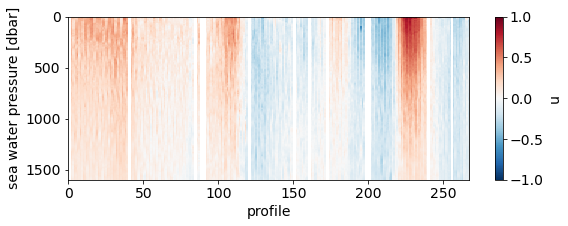

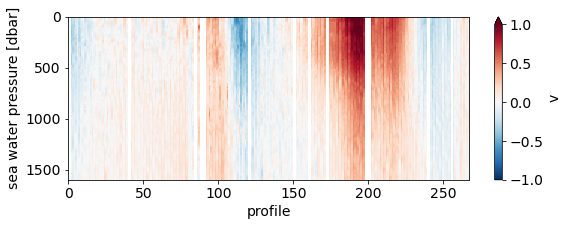

In [1364]:
float_num = ema[floatid]
lons = float_num.longitude[rs]
lats = float_num.latitude[rs]

imp.reload(vel)
u = vel.setAbsVelToNan(floatid, abs_vels_prof[floatid].u_abs)
v = vel.setAbsVelToNan(floatid, abs_vels_prof[floatid].v_abs)

u = vel.erroneous_rel_vels(u, floatid)
v = vel.erroneous_rel_vels(v, floatid)

fig, ax = plt.subplots(figsize = (9,3))
u.plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r', cbar_kwargs = dict(label = 'u'))
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (9, 3))
v.plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r', cbar_kwargs = dict(label = 'v'))
ax.invert_yaxis()

In [1345]:
bearing = np.zeros(lons.shape)*np.nan

for i in range(0, len(bearing)-1, 2):
    # bearing from surface gps to bottom of down
    lat1, lon1 = lats[i], lons[i]
    
    nonans = ~np.isnan(u[i])
    len_nonans = len(u[i].data[nonans])
    nonats = ~np.isnat(ctd_time[floatid][i])
    len_nonat = len(ctd_time[floatid][i].data[nonats])
    
    if (len_nonans > 1) & (len_nonat > 1):
        lat2, lon2 = vel.location_at_bottom(lats, lons, ctd_time[floatid], i, u, v)

        geodesic = pyproj.Geod(ellps='WGS84')
        fwd_azimuth, back_azimuth, distance = geodesic.inv(lon1, lat1, lon2, lat2)

        fwd_azimuth += 360
        fwd_azimuth = fwd_azimuth % 360

        if fwd_azimuth == 0:
            bearing[i] = np.nan
        else:
            bearing[i] = fwd_azimuth

        # bearing from bottom of down to resurface
        lat3, lon3 = lats[i+1], lons[i+1]

        fwd_azimuth, back_azimuth, distance = geodesic.inv(lon2, lat2, lon3, lat3)

        fwd_azimuth += 360
        fwd_azimuth = fwd_azimuth % 360

        if fwd_azimuth == 0:
            bearing[i+1] = np.nan
        else:
            bearing[i+1] = fwd_azimuth
    

In [1346]:
imp.reload(vel)

# along_stream = vel.floatTrackBearing(float_num, smooth_gps = True, window = 9)[rs]
along_stream = bearing

velocity_bearing = vel.uvBearing(u, v)
stream_bearing = xr.DataArray(np.tile(along_stream,(len(float_num.pressure), 1)).transpose(), dims = velocity_bearing.dims, 
                              coords = velocity_bearing.coords)

In [1347]:
# find angle between stream bearing and velocity bearing 
theta = stream_bearing - velocity_bearing

# convert to smallest angle from the along-stream bearing (-180 to 180 degrees)
theta = ((theta + 180) % 360) - 180

In [1348]:
speed = calc.speed(u, v)

In [1349]:
# calculate u and v using this new angle (converting degrees to radians)
along = speed * np.cos(theta*np.pi/180)
cross = speed * np.sin(theta*np.pi/180)

In [1350]:
ind = np.where(along.mean(dim = 'pressure') < 0)[0]
print(ind)

for i in ind:
    theta[i] = theta[i-1]


[]


In [1351]:
# calculate u and v using this new angle (converting degrees to radians)
along = speed * np.cos(theta*np.pi/180)
cross = speed * np.sin(theta*np.pi/180)

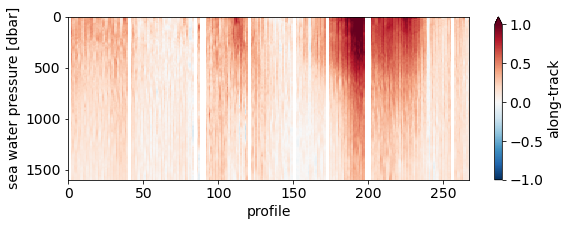

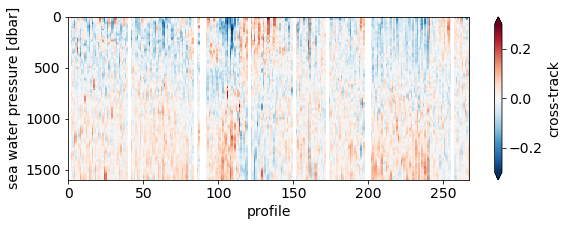

In [1352]:
fig, ax = plt.subplots(figsize = (9,3))
along.plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r', cbar_kwargs = dict(label = 'along-track'))
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (9, 3))
cross.plot(x = 'profile', vmin = -0.3, vmax = 0.3, cmap = 'RdBu_r', cbar_kwargs = dict(label = 'cross-track'))
ax.invert_yaxis()

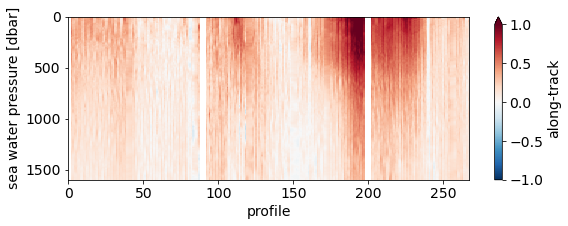

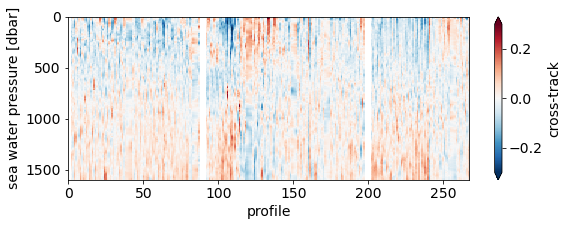

In [1353]:
along_interp = along.interpolate_na('profile',  method = 'linear', max_gap = 3)
cross_interp = cross.interpolate_na('profile', method = 'linear', max_gap = 3)

fig, ax = plt.subplots(figsize = (9,3))
along_interp.plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r', cbar_kwargs = dict(label = 'along-track'))
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (9, 3))
cross_interp.plot(x = 'profile', vmin = -0.3, vmax = 0.3, cmap = 'RdBu_r', cbar_kwargs = dict(label = 'cross-track'))
ax.invert_yaxis()

In [1354]:
imp.reload(settings)
u_no_inert = settings.half_inertial_averaging(along_interp, float_num, dim = 'profile')
v_no_inert = settings.half_inertial_averaging(cross_interp, float_num, dim = 'profile')

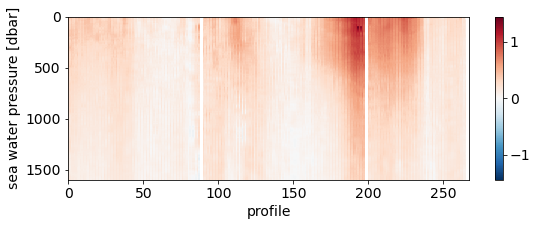

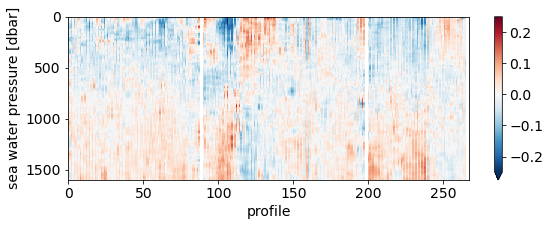

In [1355]:
fig, ax = plt.subplots(figsize = (9,3))
u_no_inert.plot(x = 'profile')
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (9,3))
v_no_inert.plot(x = 'profile', vmin = -0.25, vmax = 0.25, cmap = 'RdBu_r')
ax.invert_yaxis()

In [1356]:
t_no_inert = settings.half_inertial_averaging(float_num.time[rs], float_num, dim = 'time')

ds_no_inertial = xr.Dataset(data_vars=dict(u = (["time", "pressure"], u_no_inert.data, {'description':'absolute eastward'}),
                              v = (["time", "pressure"], v_no_inert.data, {'description':'absolute northward'}),),
                     coords = dict(pressure = ('pressure', float_num.pressure.data), 
                                   time = ('time', t_no_inert.data, {'description':'time_mid'}),))

In [1357]:
imp.reload(interp)
new_da = interp.interp_nats(ds_no_inertial.u, ds_no_inertial.u.time)
new_t = interp.interp_nats(float_num.time[rs], float_num.time[rs])

In [1358]:
u_no_inert_ = interp.interp_time(ds_no_inertial.u, float_num.time[rs])
v_no_inert_ = interp.interp_time(ds_no_inertial.v, float_num.time[rs])

In [1359]:
u_new = xr.DataArray(u_no_inert_.data, dims = u.dims, coords = u.coords)
v_new = xr.DataArray(v_no_inert_.data, dims = v.dims, coords = v.coords)

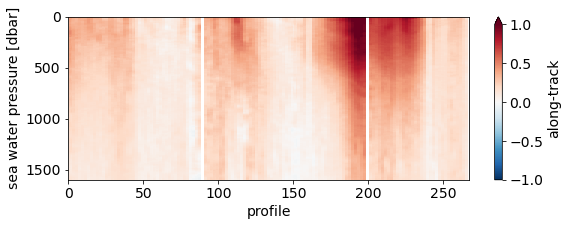

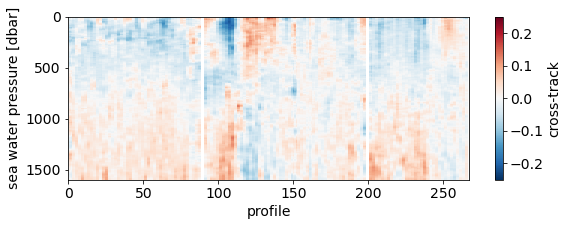

In [1360]:
fig, ax = plt.subplots(figsize = (9,3))
u_new.plot(x = 'profile', vmin = -1, vmax = 1, cmap = 'RdBu_r', cbar_kwargs = dict(label = 'along-track'))
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (9, 3))
v_new.plot(x = 'profile',  vmin = -0.25, vmax = 0.25, cmap = 'RdBu_r', cbar_kwargs = dict(label = 'cross-track'))
ax.invert_yaxis()

### Check theta 

Negative values should be to the right of the stream direction and positive values should be to the left.

Along stream values should be positive and strongest than cross-stream velocities.

Text(0.5, 1.0, 'profile 100-115')

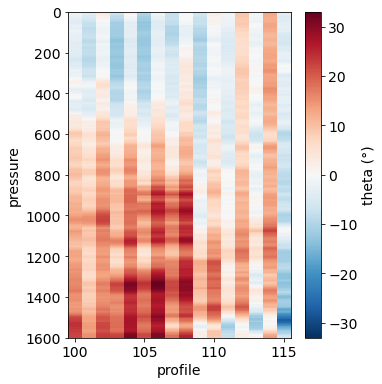

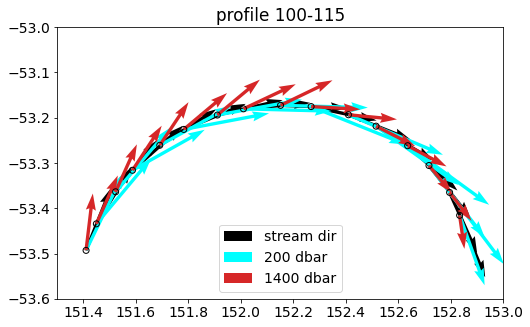

In [256]:
prof1, prof2 = 100,116
p1, p2 = 200, 1400

theta_prof = xr.DataArray(theta.data, dims = ['profile', 'pressure'], coords = dict(profile = ('profile', np.arange(0, len(theta), 1)),
                                                                                    pressure = ('pressure', theta.pressure.data)))

fig, ax = plt.subplots(figsize = (5,6))
theta_prof[prof1:prof2].plot(x = 'profile', cbar_kwargs = dict(label = 'theta (\N{DEGREE SIGN})'))
ax.invert_yaxis()


u1 = ds[floatid].u[prof1:prof2].sel(pressure = p1, method = 'nearest')
v1 = ds[floatid].v[prof1:prof2].sel(pressure = p1, method = 'nearest')

u2 = ds[floatid].u[prof1:prof2].sel(pressure = p2, method = 'nearest')
v2 = ds[floatid].v[prof1:prof2].sel(pressure = p2, method = 'nearest')

angle_rad = np.deg2rad(along_stream)
y2 = 0.3 * np.cos(angle_rad) 
x2 = 0.3 * np.sin(angle_rad) 
    
fig, ax = plt.subplots(figsize = (8, 5))
# plt.plot(lons[prof1:prof2], lats[prof1:prof2], c = 'k', alpha = 0.5)
plt.quiver(lons[prof1:prof2], lats[prof1:prof2], x2[prof1:prof2], y2[prof1:prof2], color = 'k', scale = 2)
plt.quiver(lons[prof1:prof2], lats[prof1:prof2], u1, v1, color = 'cyan', scale = 5)
plt.quiver(lons[prof1:prof2], lats[prof1:prof2], u2, v2, color = 'tab:red', scale = 3)
plt.legend(['stream dir', f'{p1} dbar', f'{p2} dbar'], loc = 'lower center')
plt.scatter(lons[prof1:prof2], lats[prof1:prof2], facecolors = 'None', edgecolors = 'k', linewidths = 1)

plt.ylim(-53.6, -53)
plt.xlim(151.3, 153)
plt.title(f'profile {prof1}-{prof2-1}')

In [257]:
shp = theta_prof.shape
diff_theta = np.zeros(shp)#*np.nan

for i in range(0, len(theta_prof), 2):
    diff_theta[i] = (theta_prof[i] - theta_prof[i+1])
#     diff_u[i+1] = (u_rel[floatid][rs][i] - u_rel[floatid][rs][i+1])

diff_theta = xr.DataArray(diff_theta, dims = ['profile', 'pressure'], coords = theta_prof.coords)    

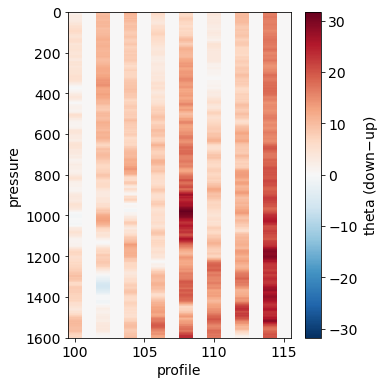

In [260]:
fig, ax = plt.subplots(figsize = (5,6))
diff_theta[prof1:prof2].plot(x = 'profile', cbar_kwargs = dict(label = 'theta (down$-$up)'))
ax.invert_yaxis()


(151.25, 151.85)

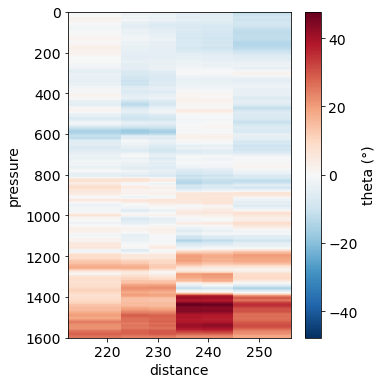

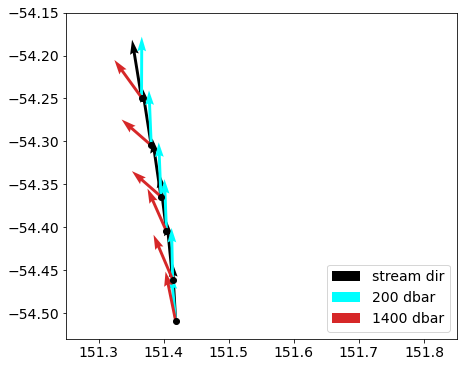

In [168]:
prof1, prof2 = 84, 90
p1, p2 = 200, 1400

fig, ax = plt.subplots(figsize = (5,6))
theta[prof1:prof2].plot(x = 'distance', cbar_kwargs = dict(label = 'theta (\N{DEGREE SIGN})'))
ax.invert_yaxis()


u1 = ds[floatid].u[prof1:prof2].sel(pressure = p1, method = 'nearest')
v1 = ds[floatid].v[prof1:prof2].sel(pressure = p1, method = 'nearest')

u2 = ds[floatid].u[prof1:prof2].sel(pressure = p2, method = 'nearest')
v2 = ds[floatid].v[prof1:prof2].sel(pressure = p2, method = 'nearest')

angle_rad = np.deg2rad(along_stream)
y2 = 0.3 * np.cos(angle_rad) 
x2 = 0.3 * np.sin(angle_rad) 
    
fig, ax = plt.subplots(figsize = (7, 6))
plt.quiver(lons[prof1:prof2], lats[prof1:prof2], x2[prof1:prof2], y2[prof1:prof2], color = 'k', scale = 2)
plt.quiver(lons[prof1:prof2], lats[prof1:prof2], u1, v1, color = 'cyan', scale = 5)
plt.quiver(lons[prof1:prof2], lats[prof1:prof2], u2, v2, color = 'tab:red', scale = 2)
plt.legend(['stream dir', f'{p1} dbar', f'{p2} dbar'], loc = 'lower right')
plt.scatter(lons[prof1:prof2], lats[prof1:prof2], c = 'k')

plt.ylim(-54.53, -54.15)
plt.xlim(151.25, 151.85)

In [36]:
floatid = 8493
float_num = ema[floatid]
rs = calc.findRSperiod(float_num)
dist = calc.distFromStart(float_num)

In [37]:
u, v = u_rot[floatid], v_rot[floatid]

In [38]:
pdens = calc.potentialDensity(ds[floatid].pressure, ds[floatid].SA, ds[floatid].CT)
levels = np.arange(26.8, 27.8, 0.05) 

In [51]:
# imp.reload(interp)
# u_rot_dens = interp.varToDens(float_num, floatid, u, pdens = pdens, by_dist = False)
# v_rot_dens = interp.varToDens(float_num, floatid, v, pdens = pdens, by_dist = False)

In [52]:
# fig, ax = plt.subplots(figsize = (10,3))
# u_rot_dens.plot(x = 'distance', vmin = -1, vmax = 1, cmap = 'RdBu_r')
# ax.invert_yaxis()
# plt.title(f'EM-{floatid}')

# fig, ax = plt.subplots(figsize = (10,3))
# v_rot_dens.plot(x = 'distance', vmin = -0.3, vmax = 0.3, cmap = 'RdBu_r')
# ax.invert_yaxis()
# plt.title(f'EM-{floatid}')

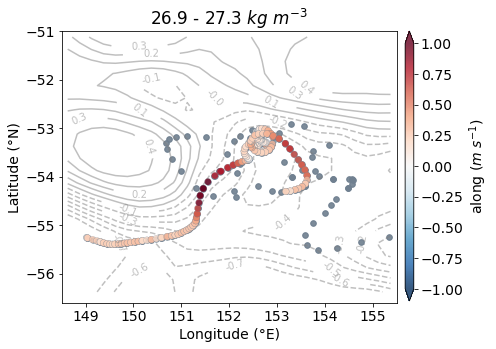

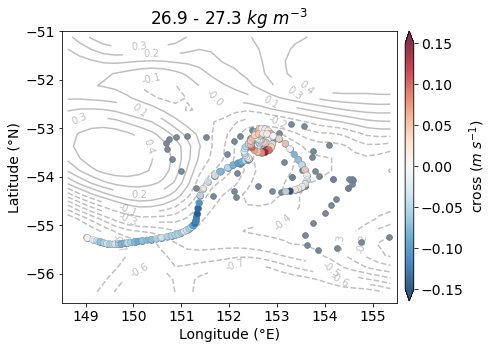

In [377]:
imp.reload(plots)

dens1, dens2 = 26.9,27.3
data = u_rot_dens
fig, ax = plt.subplots(figsize = (6,5))
                                                                    
data1 = data.sel(potential_density = slice(dens1, dens2)).mean(dim = 'potential_density')

im, msl = plots.colTrajectory(ax, data1, float_num, floatid, 
                    alt_cmems, cmap = 'RdBu_r', vmin = -1, vmax = 1, alpha = 0.8, 
                         s = 45, edgecolors = 'slategrey', linewidth = 0.25)

plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')

plt.title(f'{dens1} - {dens2} ' + '$kg$ $m^{-3}$')
cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.75])
cbar = fig.colorbar(im, cax=cbar_ax, extend = 'both', label = 'along ($m$ $s^{-1}$)')


data = v_rot_dens
fig, ax = plt.subplots(figsize = (6,5))
                                                                    
data1 = data.sel(potential_density = slice(dens1, dens2)).mean(dim = 'potential_density')

im, msl = plots.colTrajectory(ax, data1, float_num, floatid, 
                    alt_cmems, cmap = 'RdBu_r', vmin = -0.15, vmax = 0.15, alpha = 0.8, 
                         s = 45, edgecolors = 'slategrey', linewidth = 0.25)

plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')

plt.title(f'{dens1} - {dens2} ' + '$kg$ $m^{-3}$')
cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.75])
cbar = fig.colorbar(im, cax=cbar_ax, extend = 'both', label = 'cross ($m$ $s^{-1}$)')